In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np

from sklearn.datasets import load_breast_cancer, load_boston, load_digits
from tensorflow.keras.datasets.imdb import load_data as load_imdb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from skimage.transform import resize

import pymc3 as pm

from umap import UMAP

from modules.neural_networks import BayesianMLP, BayesianWordEmbedding

from modules.viz_utils import visulize_categorical_post, visulize_bernoulli_post, visualize_embedding

[autoreload of modules.layers failed: Traceback (most recent call last):
  File "C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\penthotal\miniconda3\envs\bayes_env\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\penthotal\miniconda3\envs\bayes_env\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\penthotal\Desktop\git_repositories\bayesian_ANN\modules\layers.py", line 6, in <module>
    import teano.tensor

# Binary - Breast Cancer 

In [16]:
X, y = load_breast_cancer(
    return_X_y=True
)

for tr_i, ts_i in StratifiedShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


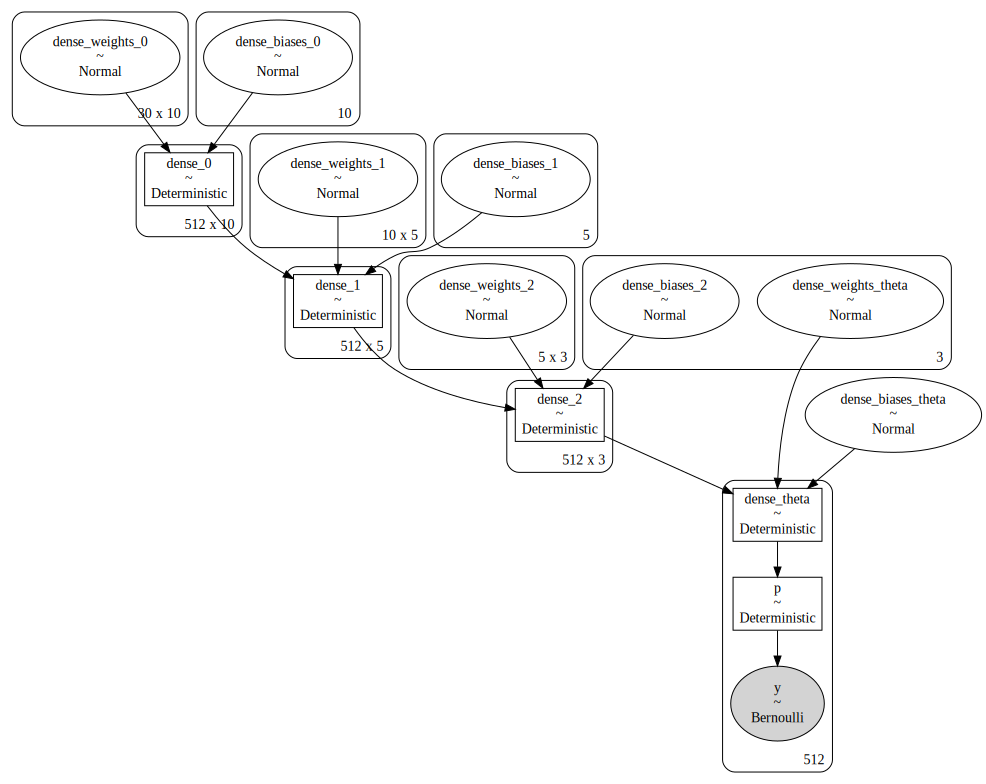

In [17]:
bernoulli_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='bernoulli_lk',
    prior=pm.Normal,
    layers=(10, 5, 3), 
    activation='tanh',
    mu=0,
    sigma=1
)
bernoulli_perceptron.show_graph()

In [18]:
bernoulli_perceptron.fit(n=100000)
bernoulli_traces = bernoulli_perceptron.predict(
    X_ts, 
    y_ts, 
    ['p'], 
    samples=3000
)

Finished [100%]: Average Loss = 12.833


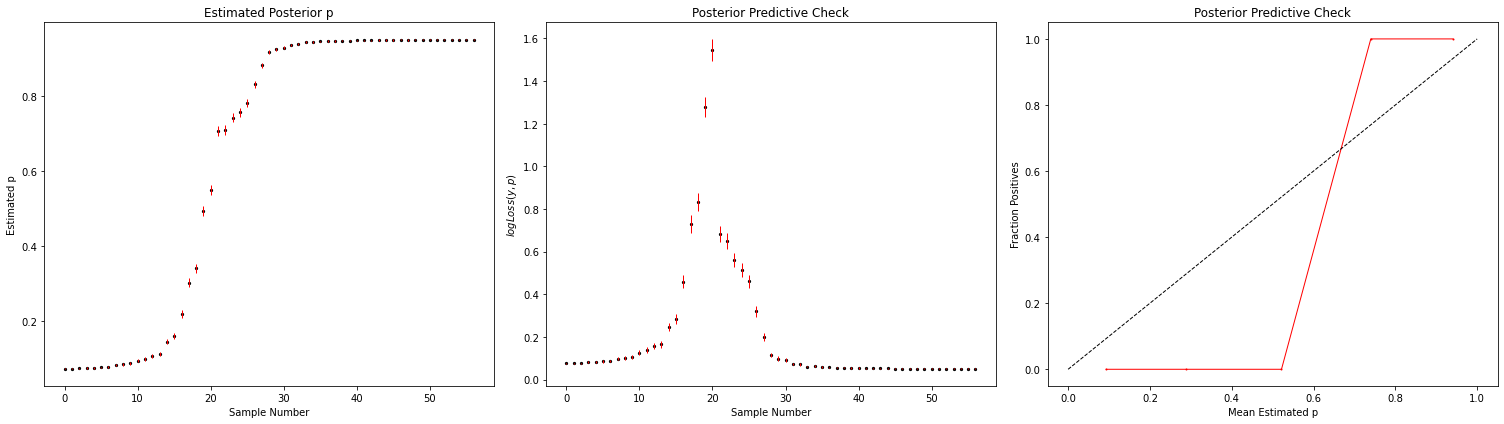

In [19]:
visulize_bernoulli_post(
    traces=bernoulli_traces, 
    y=y_ts
)

# Categorical - Digits Recognition

In [28]:
X, y = load_digits(return_X_y=True)

for tr_i, ts_i in StratifiedShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]

    scaler = MinMaxScaler()
    scaler.fit(X_tr)

    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


tanh
tanh
tanh
tanh
linear


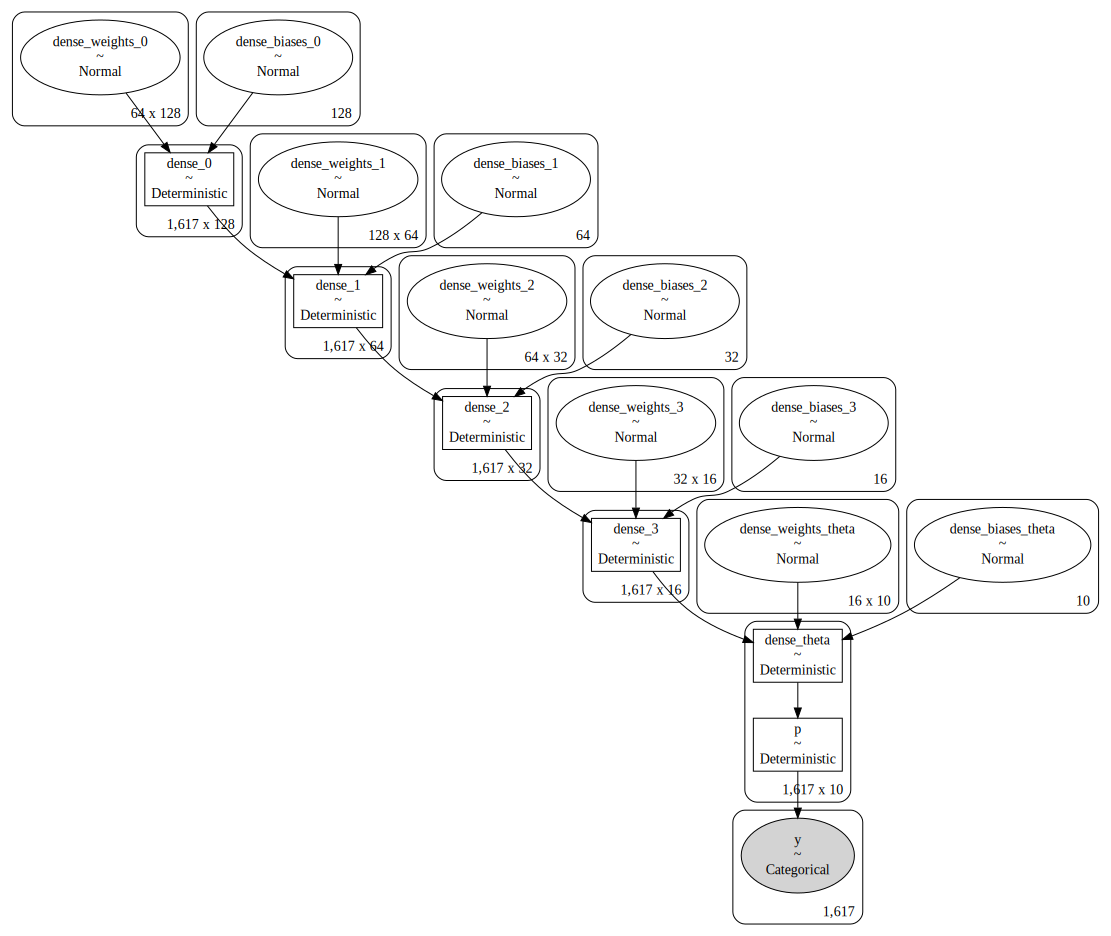

In [45]:
categorical_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=10, 
    likelyhood_model='categorical_lk',
    layers=(128, 64, 32, 16), 
    activation='tanh',
    prior=pm.Normal,
    mu=0,
    sigma=1,
    batch_size=64
)
categorical_perceptron.show_graph()

In [46]:
categorical_perceptron.fit(n=30000)
categorical_traces = categorical_perceptron.predict(
    X_ts, 
    y_ts,
    ['dense_1', 'p'],
    samples=3000
)

Finished [100%]: Average Loss = 345.6


In [47]:
categorical_traces = categorical_perceptron.predict(
    X_ts, 
    y_ts,
    ['dense_1', 'p'],
    samples=3000
)

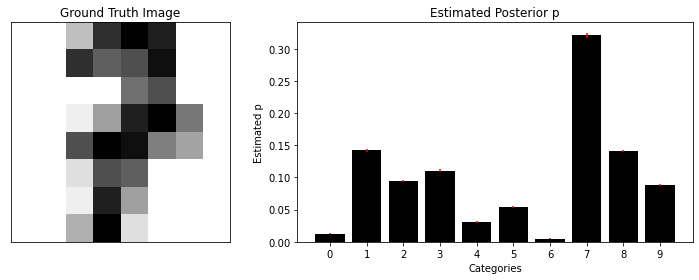

In [49]:
visulize_categorical_post(
    X=X_ts, 
    p=categorical_traces['p'],
    index=45
)

In [ ]:
visualize_embedding(
    embedding=categorical_traces['dense_1'],
    y=y_ts,
    metric='cosine',
    n_epochs=2000,
    random_state=666
)

# Normal and Student-T

In [38]:
X, y = load_boston(return_X_y=True)

for tr_i, ts_i in ShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

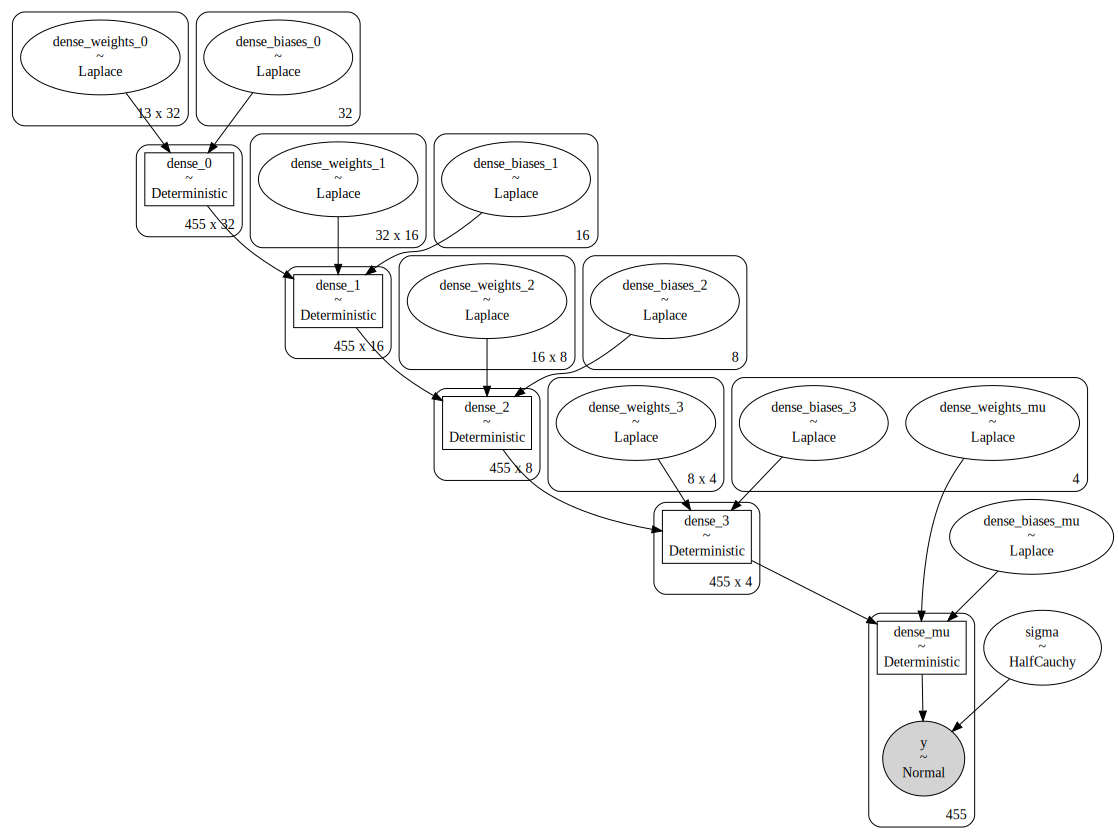

In [61]:
gaussian_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='gaussian_lk',
    layers=(32, 16, 8, 4), 
    activation='relu',
    batch_size=16,
    prior=pm.Laplace,
    mu=0,
    b=1
)
gaussian_perceptron.show_graph()

In [62]:
gaussian_perceptron.fit(n=100000)
gaussian_traces = gaussian_perceptron.predict(
    X_ts, 
    y_ts, 
    ['y']
)

Finished [100%]: Average Loss = 67.419


# Word Embedding

In [125]:
(X_tr, y_tr), (X_ts, y_ts) = load_imdb(
    skip_top=100,
    num_words=2000,
    maxlen=180
)
X_tr = pad_sequences(X_tr, padding='post', value=2)
X_ts = pad_sequences(X_ts, padding='post', value=2)

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


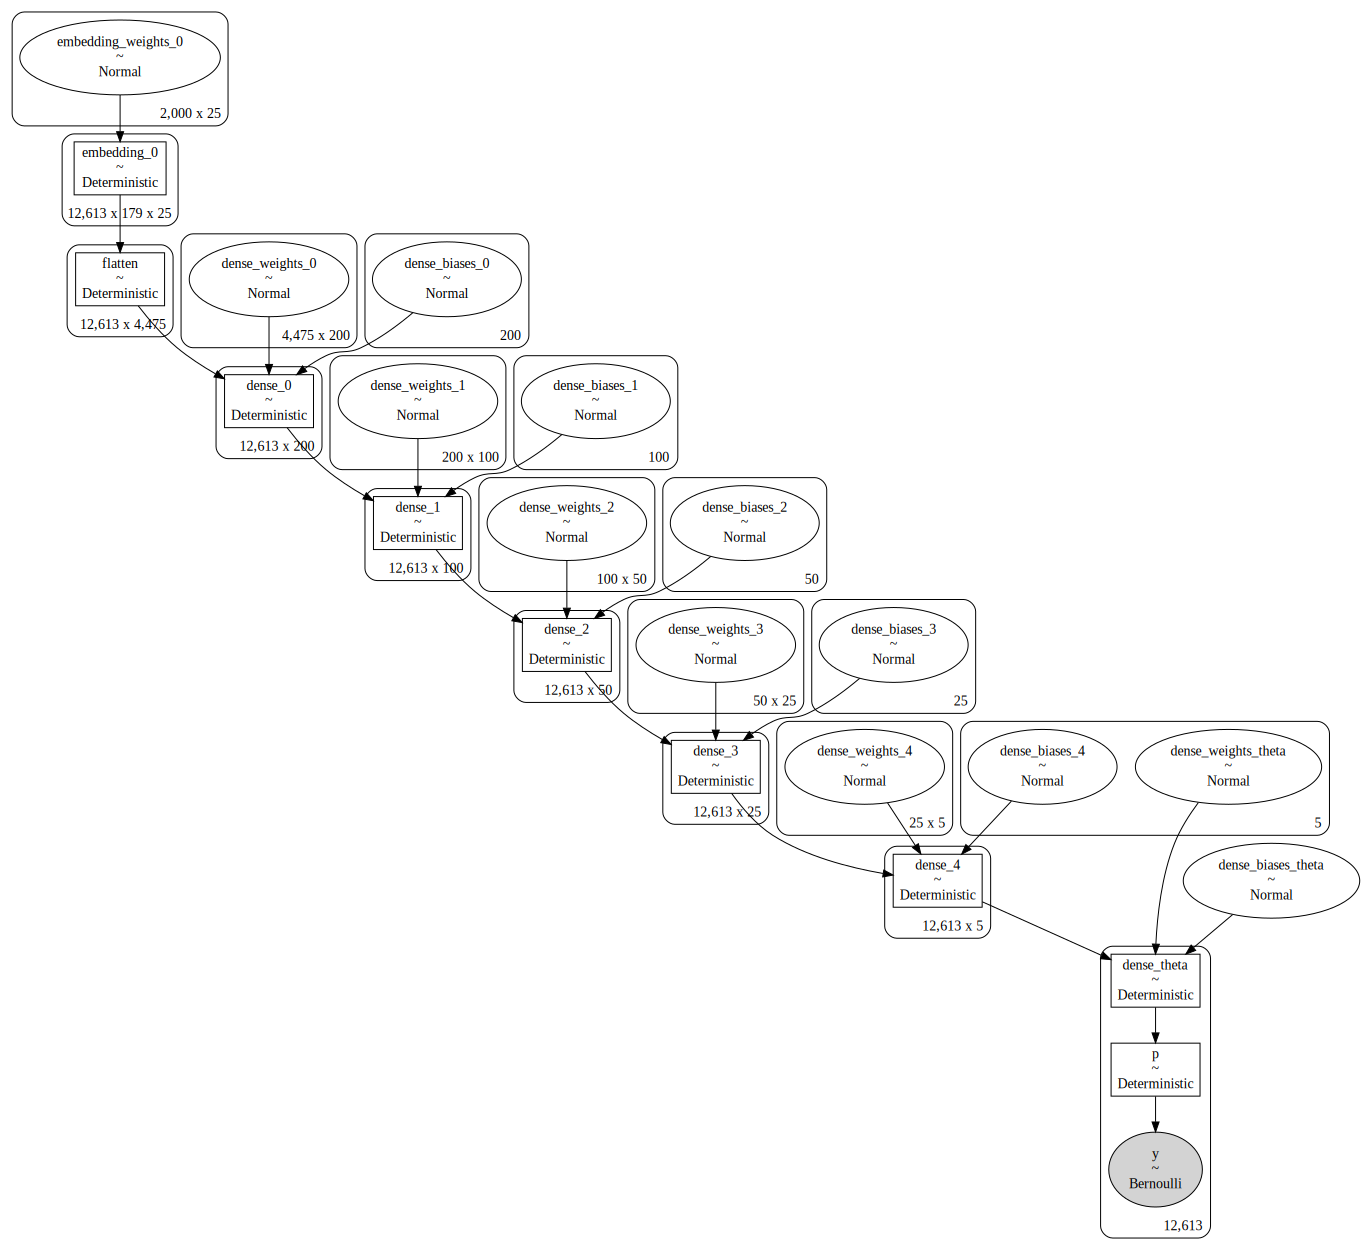

In [126]:
embedding_model = BayesianWordEmbedding(
    X_tr, 
    y_tr, 
    shape_out=1, 
    likelyhood_model='bernoulli_lk', 
    vocabulary_size=int(X_tr.max()+1), 
    embedding_size=25, 
    layers=(200, 100, 50, 25, 5),
    activation='relu', 
    prior=pm.Normal,
    mu=0,
    sigma=1,
    batch_size=256
)
embedding_model.show_graph()

In [ ]:
embedding_model.fit(n=50000)
embedding_trace = embedding_model.predict(
    X_ts, 
    y_ts, 
    ['p']
)